<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

# Object Detection

Machine-learned object detection models can be extremely useful. They are faster and often more reliable than traditional computer vision models. Additionally, we can use pretrained model weights to cut down immensely on training time.

Here's an example of what an object detector might output:



<iframe width="800" height="500"
src="https://www.youtube.com/embed/3jD02dxL6gg" 
frameborder="0" 
allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" 
allowfullscreen
style="margin: auto; display: block"></iframe>


In this exercise, you will create your own Duckietown object detection dataset. You will learn about the general structure such a dataset should follow. You will train the object detection model on that dataset ([in a subsequent notebook](../03-Training/training.ipynb). Finally, you will integrate the model into a ROS node and test the integration ([in the last notebook](../04-Integration/integration.ipynb), so that your Duckiebot knows how to recognize duckie pedestrians (and thus avoid them). You can test your object detector in simulation and on your real Duckiebot.

### Steps:

1. Setup  
2. Investigation
3. Data collection
4. Training
5. Integration



## 1. Setup

First, we need some global variables. These allow you to change the directory where we store the data you will need. You can also change the image size to reflect what your final model uses, but you can worry about that later.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATASET_DIR="../../assets/duckietown_object_detection_dataset"
IMAGE_SIZE = 416
# this is the percentage of real data that will go into the training set (as opposed to the testing set)
REAL_TRAIN_TEST_SPLIT_PERCENTAGE = 0.8

While you will build your own dataset with simulated images in part 2, it would be unreasonable to ask you to build your own dataset of real images. Run the cell below to download a dataset of pre-labelled real images.

In [3]:
import sys, os
sys.path.append("../../")

from packages.utils.misc import runp

# download dataset
if not os.path.exists(DATASET_DIR):
    runp(f"rm -rf {DATASET_DIR}/*")
    runp(f"mkdir -p {DATASET_DIR}/images")
    runp(f"mkdir -p {DATASET_DIR}/labels")
    runp(f"mkdir -p {DATASET_DIR}/train/images")
    runp(f"mkdir -p {DATASET_DIR}/train/labels")
    runp(f"mkdir -p {DATASET_DIR}/val/images")
    runp(f"mkdir -p {DATASET_DIR}/val/labels")
else:
    print("Folder structure already exists!")

# download dataset
if not os.path.exists(f"{DATASET_DIR}/frames"):
    !wget -O /tmp/dataset.zip https://duckietown-public-storage.s3.amazonaws.com/assets/mooc/2022/duckietown_object_detection_dataset.zip
    runp(f"unzip -q /tmp/dataset.zip -d $(dirname {DATASET_DIR})")
    runp(f"rm /tmp/dataset.zip")
else:
    print("Dataset already downloaded!")

Folder structure already exists!
Dataset already downloaded!


These real-world images are not the right size. Run the cell bellow to resize them (and resize the associated bounding boxes accordingly).


In [4]:
import json
import os, sys
import cv2
import numpy as np
from tqdm import tqdm
sys.path.append("../../")
from packages.utils.misc import xminyminxmaxymax2xywfnormalized, train_test_split, makedirs, runp

with open(f"{DATASET_DIR}/annotation/final_anns.json") as anns:
    annotations = json.load(anns)

In [9]:
npz_index = 0

all_image_names = []
    
def save_img(img, boxes, classes):
    global npz_index
    cv2.imwrite(f"{DATASET_DIR}/images/real_{npz_index}.jpg", img)
    with open(f"{DATASET_DIR}/labels/real_{npz_index}.txt", "w") as f:
        for i in range(len(boxes)):
            f.write(f"{classes[i]} "+" ".join(map(str,boxes[i]))+"\n")
    npz_index += 1
    all_image_names.append(f"real_{npz_index}")

filenames = tqdm(os.listdir(f"{DATASET_DIR}/frames"))
for filename in filenames:
    img = cv2.imread(f"{DATASET_DIR}/frames/{filename}")

    orig_y, orig_x = img.shape[0], img.shape[1]
    scale_y, scale_x = IMAGE_SIZE/orig_y, IMAGE_SIZE/orig_x

    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    boxes = []
    classes = []

    if filename not in annotations:
        continue

    for detection in annotations[filename]:
        box = detection["bbox"]
        label = detection["cat_name"]

        if label not in ["duckie", "cone"]:
            continue

        orig_x_min, orig_y_min, orig_w, orig_h = box

        x_min = int(np.round(orig_x_min * scale_x))
        y_min = int(np.round(orig_y_min * scale_y))
        x_max = x_min + int(np.round(orig_w * scale_x))
        y_max = y_min + int(np.round(orig_h * scale_y))

        boxes.append([x_min, y_min, x_max, y_max])
        classes.append(1 if label == "duckie" else 2)

    if len(boxes) == 0:
        continue


    boxes = np.array([xminyminxmaxymax2xywfnormalized(box, IMAGE_SIZE) for box in boxes])
    classes = np.array(classes)-1
    
    save_img(img, boxes, classes)



train_test_split(all_image_names, REAL_TRAIN_TEST_SPLIT_PERCENTAGE, DATASET_DIR)

100%|██████████| 1963/1963 [00:13<00:00, 147.22it/s]


ALL IMAGE NAMES TO MOVE DURING THIS SPLIT: ['real_1', 'real_2', 'real_3', 'real_4', 'real_5', 'real_6', 'real_7', 'real_8', 'real_9', 'real_10', 'real_11', 'real_12', 'real_13', 'real_14', 'real_15', 'real_16', 'real_17', 'real_18', 'real_19', 'real_20', 'real_21', 'real_22', 'real_23', 'real_24', 'real_25', 'real_26', 'real_27', 'real_28', 'real_29', 'real_30', 'real_31', 'real_32', 'real_33', 'real_34', 'real_35', 'real_36', 'real_37', 'real_38', 'real_39', 'real_40', 'real_41', 'real_42', 'real_43', 'real_44', 'real_45', 'real_46', 'real_47', 'real_48', 'real_49', 'real_50', 'real_51', 'real_52', 'real_53', 'real_54', 'real_55', 'real_56', 'real_57', 'real_58', 'real_59', 'real_60', 'real_61', 'real_62', 'real_63', 'real_64', 'real_65', 'real_66', 'real_67', 'real_68', 'real_69', 'real_70', 'real_71', 'real_72', 'real_73', 'real_74', 'real_75', 'real_76', 'real_77', 'real_78', 'real_79', 'real_80', 'real_81', 'real_82', 'real_83', 'real_84', 'real_85', 'real_86', 'real_87', 'real_88

Once that's done, you're all set! We'll explain how the code above worked as you continue through this notebook.

## 2. Investigation

What does an object detection dataset look like? Clearly, the specifics will depend on the convention used by specific models, but the general idea is intuitive:

- We need an image
- This image might have many bounding boxes in it, so we need some sort of list of coordinates
- These bounding boxes must be associated with a class

How are the bounding boxes defined?

![image of a bounding box](../../assets/images/bbox.png)

Some conventions use `x_min y_min width height`, whereas others use `x_min y_min x_max y_max`, and others use `x_center y_center width height`. In this exercise, the model we recommend ([YoloV5](https://github.com/Velythyl/yolov5)) uses `x_center y_center width height`.

And how do we actually obtain these bounding boxes? In real-life applications, you would need to label a dataset of images by hand. But if you have access to a simulator that is able to segment images, you could obtain the bounding boxes directly from the segmented images. 

If you take a look at Pytorch's object detection [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html), that is similar to what they do. While their images were segmented by hand, the tutorial uses the same technique that we will use here to obtain the bounding boxes. Their images look like this:

![image with bounding boxes](../../assets/images/FudanPed.png)

And they simply calculate the min and max x and y coordinates of the segmented objects to obtain the bounding box.

We will use the segmented mode in the Duckietown simulator to compute the bounding boxes of non-segmented images.

#### What we want to detect

The goal of this exercise is to make Duckietown safer: we want to be able to detect duckie pedestrians on the road and avoid squishing them. We also want to detect trucks, buses, and cones. Here is the complete list, along with their corresponding IDs:

| Object    | ID    |
| ---       | ---   |
| Duckie    | 0     |
| Cone      | 1     |
| Truck     | 2     |
| Bus       | 3     |

## 3. Data collection


### Tool and Format

We are going to supplement the data from the real dataset that we already downloaded with data automatically *generated from the simulator*.  The script we will use for this is the [data_collection.py](../../packages/utils/data_collection.py) file. You can edit the file in order to change the some parameters on what to generate, e.g. the number of images generated, which maps to be used by the simulator. More parameters (with description) can be found in the file, under the comment line:

![img](../../assets/images/setup_instr_data_col_0.png)


The purpose of the [data_collection.py](../../packages/utils/data_collection.py) script is to automatically generate data for you from the simulator. 
In the rest of this activity we will walk step by step through the process. 

Of course, your dataset's format depends heavily on your model. If you want to use the [YoloV5](https://github.com/duckietown/yolov5) model that we suggest, you should closely follow their [guide on how to train using custom data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data). Your data should follow the following directory structure:

![image of dataset save format](../../assets/images/dataset_format.png)

The dataset is called `duckietown_object_detection_dataset` and is stored inside the `assets/` directory of this learning experience.
We have created two subdirectories in that folder: `train` and `val`. Both these directories should contain two subdirectories, `images` and `labels`. Inside `images`, you must place your images, and inside `labels`, you must place the images' bounding boxes data. Notice that the label files use the same name as their corresponding image files but with a different extension. In other words, the data for `0.jpg` can be found in `0.txt`.

The format for the label files is fairly simple. For each bounding box in the corresponding image, write a row of the form `class x_center y_center width height`. Keep in mind that the pixel data must be 0-to-1 normalized (i.e., you can calculate the usual `x_center y_center width height` in pixel space and divide by the image's size). For example,

    0 0.5 0.5 0.2 0.2
    1 0.60 0.70 0.4 0.2

this says "there is a duckie (class 0) centered in the image, whose width and height are 20% of the image's. There is also a cone (class 1) whose center is at 60% of the image's maximal x value and 70% of the image's maximal y value, and its width is 40% of the image's own while its height is 20%."

Again, it is recommended that you read the guide posted on YoloV5's GitHub: [guide on how to train using custom data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data).

### Running data collection

After you're done editing the [data_collection.py](../../packages/utils/data_collection.py) file, we will need to run it against the simulator.
We will do that through this activity's virtual desktop environment. (Run the following 2 commands from the root directory of this activity)

* First, let's prepare the environment for this activity to run in.

    ```shell
    dts code build
    ```

* Then, access this activity's virtual desktop (also known and referred to as `VNC`) by ,

    ```shell
    dts code workbench --simulation --launcher data-collection
    ```

* Open the VNC with the URL that you see on screen, among the terminal logs
    * Cmd/Ctrl + Click on the link, or
    * Copy-paste the link to your browser address bar
    * The link looks like this:
    ![](../../assets/images/setup_instr_vnc.png)



Then, click the "Data Collection" icon on the desktop. 
This will run your [data_collection.py](../../packages/utils/data_collection.py) script file.

You will see a simulator view and the agent moving while collecting images. The process will load different maps and randomize time of day, starting location and heading and other aspects of the environment. Wait until the simulator view window and the terminal terminate and close automatically.

* This is what you should expect to see. The collection progress is shown in the terminal. The image view shows the segmented scene, while we save the original image for training (see next section). 
    ![](../../assets/images/setup_instr_data_col_1.png)

Later, if you edit the script again in this editor, you need to close the "Data Collection" application and click on the icon again for the changes to have an effect. Also, remove the images in `assets/duckietown_object_detection_dataset/[train|val]/images` folders, which do NOT start with `real_`.

Once satisfied, you can close the VNC browser tab and terminate the `dts code workbench` command above by pressing Ctrl-C in your terminal.

### Data generation/collection procedure explained

In this section, we take some sample images and illustrate how the data collection script generates labels for the data from our simulator.

#### 1. Take the segmented image (this is provided to you by the simulator's rendering engine)

In [10]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
mapping = {
    "house": "3deb34",
    "bus": "ebd334",
    "truck": "961fad",
    "duckie": "cfa923",
    "cone": "ffa600",
    "floor": "000000",
    "grass": "000000",
    "barrier": "000099"
}
mapping = {
    key:
        [int(h[i:i+2], 16) for i in (0,2,4)]
    for key, h in mapping.items()
}

In [11]:
# Feel free to experiment with a few other files in the images folder. All of the original/segmented pairs are labeled as *_not_seg and *_seg
obs = np.asarray(Image.open('../../assets/images/duckie_not_seg.png'))
obs_seg = np.asarray(Image.open('../../assets/images/duckie_seg.png'))
# define the mapping from objects to colours


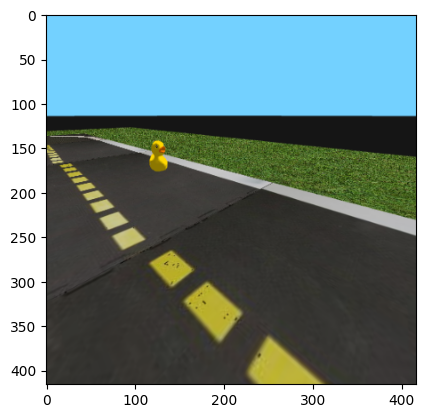

In [12]:
plt.imshow(obs)

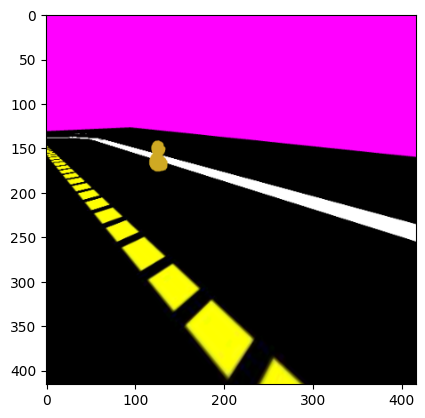

In [13]:
plt.imshow(obs_seg)

#### 2. Remove colors we are not interested in

The function below removes all colors that do not match the given class name.
We use this to isolate the objects of interest by isolating their respective color first.

In [14]:
import sys
sys.path.append("../../")
from packages.solution.setup_activity import segmented_image_one_class

Let's test it out by removing everything that is not a duckie in the image above.

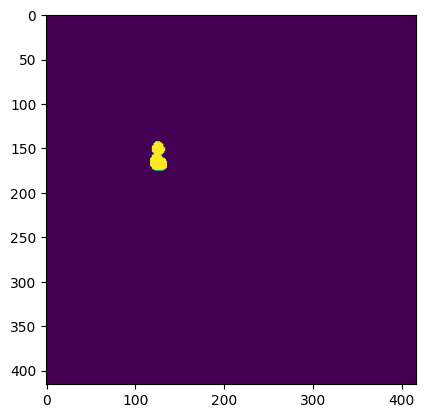

In [15]:
duckie_masked_image = segmented_image_one_class(np.asarray(obs_seg),"duckie")
plt.imshow(duckie_masked_image)

#### 3. Find bounding boxes around each unique instance within the image

The function below isolates the object by finding the contours of the colored blob in the image above.

This results in the bounding box around the object.

In [16]:
import sys
sys.path.append("../../")
from packages.solution.setup_activity import find_all_bboxes

The function below takes the original image and computed bounding boxes and superimposes the bounding boxes to the image.

In [17]:
def show_image_with_boxes(img, boxes):
    import matplotlib.patches as patches
    fig, ax = plt.subplots()
    ax.imshow(img)
    for box in boxes:
        rect = patches.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    

Let's test these functions out on the image above.

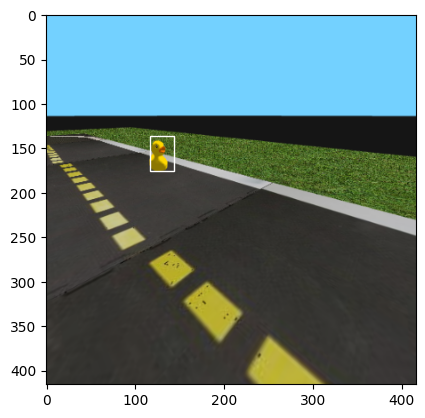

In [18]:
boxes = find_all_bboxes(duckie_masked_image)
show_image_with_boxes(obs,boxes)


#### 4. Let's do that but for all classes

In [19]:
import sys
sys.path.append("../../")
from packages.solution.setup_activity import find_all_boxes_and_classes

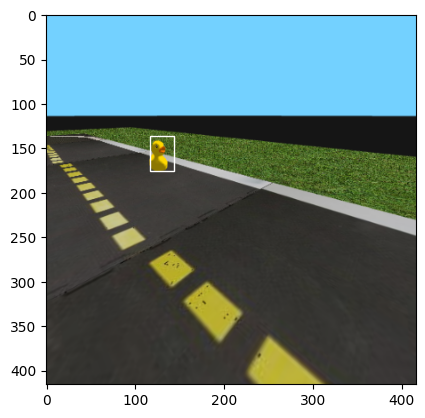

In [20]:
all_boxes, all_classes = find_all_boxes_and_classes(obs_seg)
show_image_with_boxes(obs, all_boxes)


Finally we save the ***non-segmented*** version of the image, and write its bounding boxes + their classes to a corresponding txt file. The above steps demonstrate what is implemented in the [data_collection.py](../../packages/utils/data_collection.py) file.

### Combining with the real dataset & training/test set splits

When training supervised learning models, one must worry about overfitting to the training set. If you can keep *some* of your dataset *out* of your training data, you can use it to verify that your model does not overfit to your dataset by *testing* it on the data you left out. We call this chunk of data the *validation set*. 

You can experiment with the `REAL_TRAIN_TEST_SPLIT_PERCENTAGE` variable defined at the top of this notebook. Tune its value to adjust the percentage of the **real** data that is used for training as opposed to testing. There is a similar variable defined in [data_collection.py](../../packages/utils/data_collection.py), called `SIMULATED_TRAIN_SPLIT_PERCENTAGE` which controls the percentage of the **simulated** data that will be used for training.

# Next step

You can continue with the [Training notebook](../03-Training/training.ipynb)